In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='4'
import sys

sys.path.append('../')

import numpy as np
import sys
import scipy.ndimage as nd
import json
import pickle
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from models.resnet import *
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import time
import math
from utils.utils import AverageMeter
from datasets.FattyLiverDatasets import FattyLiverClsDatasetsDiff3D
from train.train_diff_3d_cls2 import test

import torch.nn.functional as F

import scipy.ndimage as nd
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
config_file = '../config/config_diff_3d.json'
with open(config_file,encoding='gb2312') as f:
    config = json.load(f)
config

{'train_list_file': '',
 'val_list_file': '',
 'test_list_file': '',
 'model_dir': '../data/experiment_0/9.model_3d_cls5_exp1',
 'num_classes': 5,
 'phase': 'train',
 'model': 'resnet34',
 'weight': None,
 'lr': 0.001,
 'mom': 0.9,
 'wd': 0.0001,
 'fix': 50,
 'step': 20,
 'epoch': 120,
 'display': 100,
 'num_workers': 8,
 'batch_size': 12,
 'dim_z': 128,
 'dim_x': 128,
 'optimizer': 'sgd'}

In [3]:
batch_size = 1
num_workers = 4
phase = 'train'
epochs = 10000
display = 2

crop_size = [16, 384, 512]

In [4]:
model = resnet34(num_classes=2, 
                 shortcut_type=True, 
                 sample_size_y=crop_size[1], 
                 sample_size_x=crop_size[2], sample_duration=crop_size[0])
# pretrained_weights = '../data/experiment_0/9.model_cls2/ct_pos_recogtion_20200818181003/ct_pos_recognition_0561_best.pth'
# pretrained_weights = '../data/experiment_0/9.model_cls2/ct_pos_recogtion_20200818181003/ct_pos_recognition_0022_best.pth'
pretrained_weights = '../data/experiment_0/9.model_cls2/ct_pos_recogtion_20200818181003/ct_pos_recognition_0001_best.pth'
# pretrained_weights = '../data/experiment_0/9.model_cls2_exp1/ct_pos_recogtion_20200819102752/ct_pos_recognition_0000_best.pth'
# pretrained_weights = '../data/experiment_0/9.model_cls2_exp1/ct_pos_recogtion_20200819110631/ct_pos_recognition_0004_best.pth'
# pretrained_weights = '../data/experiment_0/9.model_cls2_exp1/ct_pos_recogtion_20200819110631/ct_pos_recognition_0047_best.pth'
# pretrained_weights = '../data/experiment_0/9.model_cls2_exp1/ct_pos_recogtion_20200820135922/ct_pos_recognition_0054_best.pth'
# pretrained_weights = '../data/experiment_0/9.model_cls2_exp1/ct_pos_recogtion_20200820135922/ct_pos_recognition_0022_best.pth'
pretrained_weights = '../data/experiment_0/9.model_cls2_exp1/ct_pos_recogtion_20200821154002/ct_pos_recognition_0032_best.pth'
pretrained_weights = '../data/experiment_0/9.model_cls2_exp1/ct_pos_recogtion_20201013175544/ct_pos_recognition_0013_best.pth'
model.load_state_dict(torch.load(pretrained_weights))

../models/resnet.py:233: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


<All keys matched successfully>

In [5]:
data_root = '../data/experiment_0/0.ori'
config_test = '../data/config/config_test.txt'
test_ds = FattyLiverClsDatasetsDiff3D(data_root, config_test, crop_size)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                                    num_workers=num_workers, pin_memory=False)

====> fatty liver count is:34


In [6]:
criterion = nn.CrossEntropyLoss().cuda()
acc, logger, tot_pred, tot_label, tot_prob = test(test_dataloader, nn.DataParallel(model).cuda(), criterion, 0, 10)
print(acc)

../train/train_diff_3d_cls2.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  tot_prob = np.append(tot_prob, F.softmax(output).cpu().detach().numpy()[:,1])


Epoch: [0][9/34]	Time 0.088605 (0.144)	Data 0.049	Loss 0.6189	Accuray 0.6000
Epoch: [0][19/34]	Time 0.089510 (0.117)	Data 0.027	Loss 0.7194	Accuray 0.5500
Epoch: [0][29/34]	Time 0.090229 (0.109)	Data 0.019	Loss 0.7015	Accuray 0.6000
[1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
[0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1]
0.5588235294117647


In [7]:
def plot_roc(y_true, y_pred, class_name='dr'):
    print('\n====> plot {} info:\n'.format(class_name))
    log = []
    from sklearn import metrics
    def calc_metrics_table(y_true, y_pred, thresholds):
        metrics_list = list()
        for threshold in thresholds:
            y_pred_binary = np.zeros(y_pred.shape, dtype=np.uint8)
            y_pred_binary[y_pred>threshold] = 1
            tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred_binary).ravel()
            print('tn:{:.3f}\tfp:{:.3f}\tfn:{:.3f}\ttp:{:.3f}\t'.format(tn, fp, fn, tp))
            accuracy = (tp+tn)/(tn+fp+fn+tp)
            sensitivity = tp/(tp+fn)
            specificity = tn/(fp+tn)
            ppv = tp/(tp+fp)
            npv = tn/(tn+fn)
            metrics_list.append([threshold, accuracy, sensitivity, specificity, ppv, npv])
        metrics_table = pd.DataFrame(np.array(metrics_list), columns=['threshold','accuracy','sensitivity','specificity','ppv','npv'])
        return metrics_table


    fpr, tpr, thres = metrics.roc_curve(y_true, y_pred)

    auc = metrics.auc(fpr, tpr)

    thresholds = np.arange(0.05, 1., 0.05)
    metrics_table = calc_metrics_table(y_true, y_pred, thresholds)

    print('\nAUC:%.4f\n'% auc)
    log.append('AUC:%.4f'% auc)

    plt.figure()
    plt.title('{} roc curve'.format(class_name))
    plt.plot(fpr, tpr, 'r')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.xticks(np.arange(0, 1.1, step=0.1))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.grid(ls='--')
    plt.show()

    print(metrics_table)
    log.append(metrics_table)
    return log


====> plot fatty liver classification 2 info:

tn:0.000	fp:14.000	fn:0.000	tp:20.000	
tn:0.000	fp:14.000	fn:0.000	tp:20.000	
tn:0.000	fp:14.000	fn:0.000	tp:20.000	
tn:0.000	fp:14.000	fn:0.000	tp:20.000	
tn:0.000	fp:14.000	fn:0.000	tp:20.000	
tn:1.000	fp:13.000	fn:0.000	tp:20.000	
tn:1.000	fp:13.000	fn:2.000	tp:18.000	
tn:1.000	fp:13.000	fn:2.000	tp:18.000	
tn:1.000	fp:13.000	fn:3.000	tp:17.000	
tn:2.000	fp:12.000	fn:3.000	tp:17.000	
tn:3.000	fp:11.000	fn:9.000	tp:11.000	
tn:7.000	fp:7.000	fn:12.000	tp:8.000	
tn:10.000	fp:4.000	fn:14.000	tp:6.000	
tn:11.000	fp:3.000	fn:17.000	tp:3.000	
tn:14.000	fp:0.000	fn:19.000	tp:1.000	
tn:14.000	fp:0.000	fn:20.000	tp:0.000	
tn:14.000	fp:0.000	fn:20.000	tp:0.000	
tn:14.000	fp:0.000	fn:20.000	tp:0.000	
tn:14.000	fp:0.000	fn:20.000	tp:0.000	

AUC:0.4321



/home/zhangwd/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/home/zhangwd/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


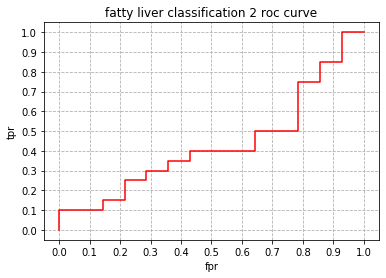

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.05  0.588235         1.00     0.000000  0.588235       NaN
1        0.10  0.588235         1.00     0.000000  0.588235       NaN
2        0.15  0.588235         1.00     0.000000  0.588235       NaN
3        0.20  0.588235         1.00     0.000000  0.588235       NaN
4        0.25  0.588235         1.00     0.000000  0.588235       NaN
5        0.30  0.617647         1.00     0.071429  0.606061  1.000000
6        0.35  0.558824         0.90     0.071429  0.580645  0.333333
7        0.40  0.558824         0.90     0.071429  0.580645  0.333333
8        0.45  0.529412         0.85     0.071429  0.566667  0.250000
9        0.50  0.558824         0.85     0.142857  0.586207  0.400000
10       0.55  0.411765         0.55     0.214286  0.500000  0.250000
11       0.60  0.441176         0.40     0.500000  0.533333  0.368421
12       0.65  0.470588         0.30     0.714286  0.600000  0.416667
13       0.70  0.411

In [8]:
log = plot_roc(np.array(tot_label, dtype=np.float32), np.array(tot_prob), 'fatty liver classification 2')